# pyEMIS Example usage

A simple example of how to use the pyEMIS tools to generate a smartspaces-like analysis.

## Import some stuff for the demo

These imports are just used to make an example dataset.

In [1]:
from datetime import datetime, timedelta
import time

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Import the pyEMIS factories

Each factory has a role in composing a model. The constant and heating3 factories are for generating the basic models. The _any_ factory implements a model selection algorithm to choose from the two sub-models and the _weekly_ factory divides data into 336 sub-models to represent the weekly occupancy pattern. 

In [2]:
from pyEMIS.models.any import Factory as AF
from pyEMIS.models.weekly import Factory as WF
from pyEMIS.models.constant import Factory as c
from pyEMIS.models.heating3 import Factory as h3

# Compose a concrete model factory

Here we compose the various factory classes into a concrete, usable weekly factory instance. The _weekly_ factory uses the passed in _any_ factory for each sub-model and the _any_ factory will choose between constant or heating models. This structure should allow for more model types to be added easily.

In [3]:
factory = WF(AF([c(), h3()]))

## Create a fake dataset
Just some silly mucking about to create a fake dataset.

/home/graeme/.virtualenvs/pyEMIS/local/lib/python3.4/site-packages/numpy/lib/shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


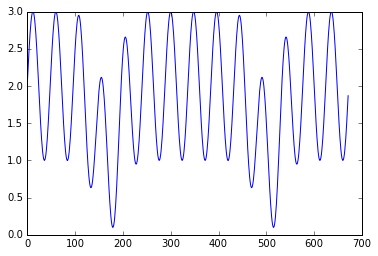

In [4]:
n = 336 * 53 # 53 weeks of half-hourly data

#a series of datetimes starting in March
start = datetime.now().replace(month=3) - timedelta(minutes=(n * 30))
dt = [start + timedelta(minutes=i * 30) for i in range(n)]

# some patterns to make it interesting
diurnal = np.tile(np.sin((2*np.pi/48) * np.arange(48) + 24), n/48)
seasonal = np.sin((2*np.pi/(336*52)) * np.arange(n))
occupancy = np.tile(
    np.sin((2 * np.pi / 48) * np.arange(336)) -
    np.abs(np.power(np.sin((2 * np.pi / (2 * 336)) * np.arange(336)), 18)) + 2, n / 336
)

#Simple temperature data
temperature = (diurnal * 5) + (seasonal * 15) * 0.5 + 10

#degree days at base 15.5
dd = np.array([max(0, 15.5 - t) for t in temperature])

# Consumption
consumption = dd * occupancy + (10 * occupancy)
consumption = consumption + np.random.randn(n) * np.mean(consumption) * 0.25

plt.plot(occupancy[:336*2])

In [5]:
timestamps = [time.mktime(t.timetuple()) for t in dt]
data = np.array(list(zip(consumption, temperature, timestamps)), dtype=[('value', 'int32'), ('temperature', 'int32'), ('timestamp', 'float')])

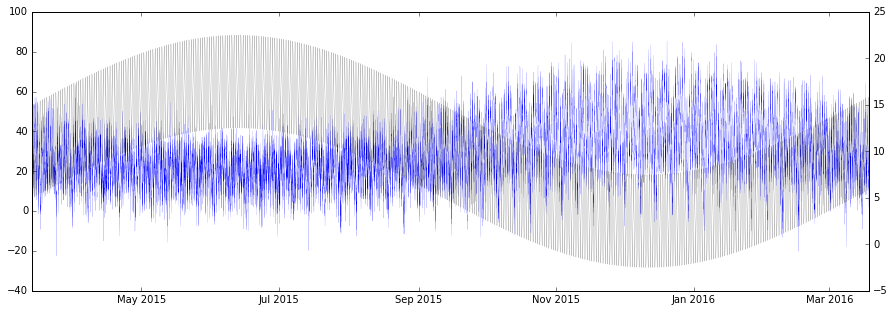

In [6]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()
ax1.plot(dt, consumption, color='blue', lw=0.1)
ax2.plot(dt, temperature, color='black', lw=0.25, alpha=0.5)

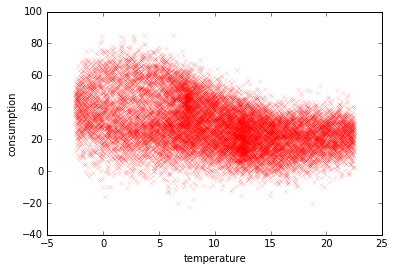

In [7]:
plt.scatter(temperature, consumption, marker='x', color='red', lw=0.1, alpha=0.9)
plt.xlabel('temperature')
plt.ylabel('consumption')

## Create a baseline model
Here we pass data into the factory to generate a model instance. The model stores its own parameters and residuals. It uses these to generate predictions and analysis.

In [8]:
model = factory(data[:17520])

## Generate a core model prediction
The `model.prediction` method returns the central prediction of the model. This can be useful for estimating savings and as the core of a performance analysis.

In [9]:
preds = model.prediction(data)

## Generate percentiles boundaries
The `model.scoreatpercentile` method is used to generate consumption values for a specified percentile. Here we generate a dictionary of datasets. This method calculates the percentile of the model residuals and adds it to the core prediction.

In [ ]:
percs = {"P{}".format(p): model.scoreatpercentile(data, p) for p in [10, 25, 50, 75, 90]}

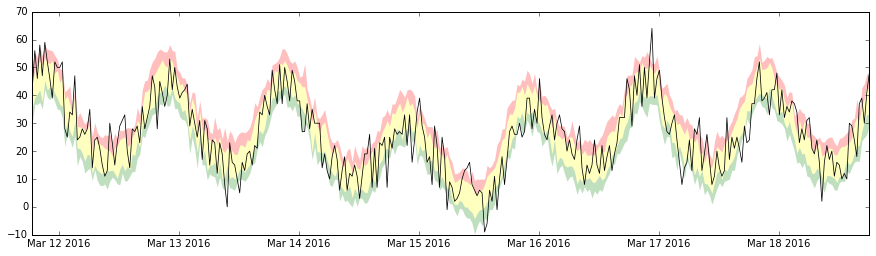

In [10]:
plt.figure(figsize=(15, 4))
plt.fill_between(dt[-336:], percs['P10'][-336:], percs['P25'][-336:], color='green', lw=0, alpha=0.25)
plt.fill_between(dt[-336:], percs['P25'][-336:], percs['P75'][-336:], color='yellow', lw=0, alpha=0.25)
plt.fill_between(dt[-336:], percs['P75'][-336:], percs['P90'][-336:], color='red', lw=0, alpha=0.25)
plt.plot(dt[-336:], data[-336:]['value'], color='black', lw=0.75)

## Generate the percentile values 
The percentile values of a given consumption value is our performance indicator.

In [ ]:
smileys = model.percentileofscore(data)

The chart shows that this is pretty much random in our dataset.

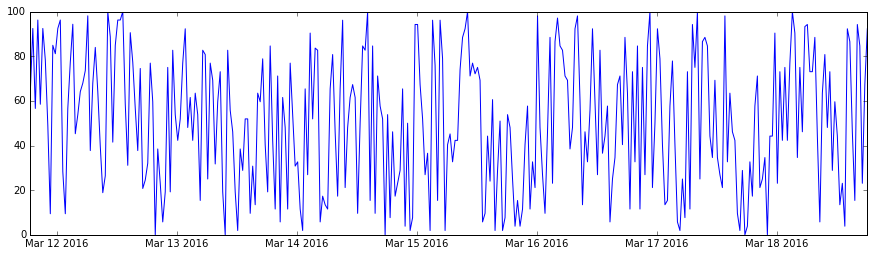

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(dt[-336:], smileys[-336:])